In [ ]:
# %pip install xarray gcsfs google-cloud fsspec
# %pip install dask
# %pip install dask-expr
# %pip install zarr
# %pip install jinja2

## Library Imports

In [1]:
# Cloud Storage handling libraries
from google.cloud import storage
import gcsfs
import fsspec

# Xarray & Dask Functionalities
import xarray as xr
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from dask import delayed, compute

import pandas as pd
import numpy as np

## Building our Pipeline

In [2]:
class CMIP6_Pipe:
    # ECMWF Data Initialization Method
    def __init__(self, bucket='cmip6'):
        self.bucket = bucket
        self.main_directory = f'CMIP6/HighResMIP/ECMWF/ECMWF-IFS-HR/highresSST-present/r1i1p1f1'
        try:
            # Connect to the GCS CMIP6 Bucket
            self.storage_client = gcsfs.GCSFileSystem(project = self.bucket)
        except:
            print('Error connecting...')
    
    def select_time_var(self, temporal_unit = 'Amon', climate_var = 'ta'):
        # Path that is generated depending on time and climate variable being accessed
        directory = f'{self.main_directory}/{temporal_unit}/{climate_var}/gr/v20170915'

        # Open ZARR Archives Xarray
        ds = xr.open_zarr(
            self.storage_client.get_mapper(f'gs://{self.bucket}/{directory}'),
            chunks = {'time' : 12}
        )[climate_var]

        return ds

In [3]:
data_pipe = CMIP6_Pipe()
data_pipe

In [13]:
ds = data_pipe.select_time_var()
# ds.sel(plev = 5000, time = slice('2004-01-01', '2005-04-01'))[0].plot()
jan_2004_ta = ds.sel(plev=5000, time=slice('2004-01-01', '2005-04-01'))[0]

# Convert to celsius
jan_2004_ta = (jan_2004_ta - 273.15)

# Fix the Longitute [0, 360] --> [-180, 180]
jan_2004_ta.coords['lon'] = (jan_2004_ta.coords['lon'] + 180) % 360 - 180
jan_2004_ta = jan_2004_ta.sortby(jan_2004_ta.lon).compute()

/Users/shadowclone/Documents/BDA696/code/BDA-696/.venv/lib/python3.12/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 12. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


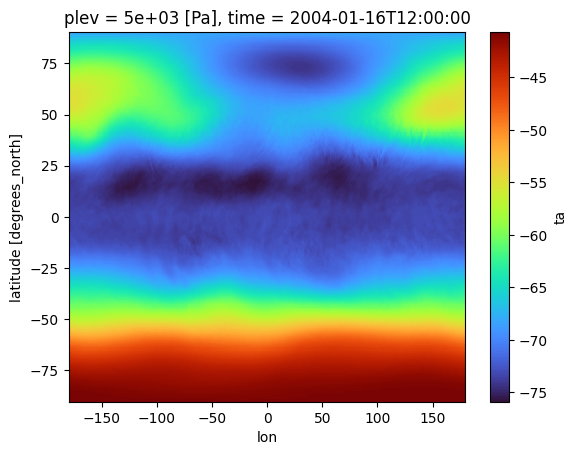

In [14]:
jan_2004_ta.to_netcdf('export.nc')
jan_2004_ta.plot(cmap = 'turbo')